In [ ]:
# mount drive into colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# change directory
%cd '/content/drive/MyDrive/Rahnema/Rahnema-College-Team'

/content/drive/.shortcut-targets-by-id/1mN07jhPqKcfkME6GxvaJOdBZWSwOA7AN/Rahnema-College-Team


***
# Load data

In [ ]:
import pandas as pd

In [ ]:
df_train = pd.read_csv('df_for_modeling.csv')
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,97,98,99,num_req,img2req,font2req,js2req,css2req,ico2req,txt2req,is_308,is_408,is_413,is_206,is_405,is_499,is_301,is_307,is_101,is_head,is_post,is_put,is_get,robots,depth_request,is_5,is_6,is_7,is_8,is_9,is_10,is_11,is_12,is_13,is_14,is_15,mean_gap,std_gap,response_time,size
0,-0.220596,0.140431,-0.080571,0.031185,-0.067035,-0.133755,0.012261,0.037123,-0.097730,-0.034056,-0.124645,-0.087050,0.124957,-0.012067,-0.027049,-0.212914,-0.061061,0.024364,-0.188440,-0.023130,-0.049763,-0.040351,0.011208,-0.044263,-0.138748,-0.007235,0.115858,-0.050060,0.227324,0.045195,-0.197757,-0.085541,-0.013567,0.027166,-0.229397,-0.211299,0.049236,0.042789,-0.047194,-0.143684,...,0.228639,-0.049791,0.012252,7,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,7,0.0,0.000000,0,0,0,0,0,0,7,0,0,0,0,0.714286,1.496026,41.714286,108702.714286
1,-0.168698,0.281958,-0.031812,-0.058086,0.129094,-0.150727,-0.230596,0.136277,-0.120125,0.247125,-0.076490,-0.052943,0.058686,0.262032,-0.038127,-0.085640,0.187354,-0.102527,-0.282762,-0.102065,-0.041508,0.060192,0.109080,-0.192681,-0.133040,-0.139701,-0.119031,-0.085953,0.391279,-0.173646,-0.606426,-0.012260,-0.048398,0.052289,-0.285869,-0.243788,0.271892,-0.072134,-0.154696,-0.229794,...,0.104721,-0.275927,0.297340,28,8.0,2.0,3.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,28,0.0,0.507875,0,0,0,0,28,0,0,0,0,0,0,0.000000,0.000000,25.428571,48159.571429
2,-0.116496,-0.045110,0.029045,-0.072870,-0.057928,0.143148,0.048527,0.057002,0.192723,0.184100,0.123650,0.092633,-0.094634,-0.124143,0.225659,-0.190998,0.055717,0.025035,0.112337,-0.024111,-0.234882,-0.076103,0.030267,-0.087555,0.029647,0.022248,0.003675,0.196727,-0.021994,0.187134,-0.036379,-0.026733,0.085641,-0.176903,0.154596,-0.085364,0.094146,0.131253,0.038813,-0.000810,...,-0.093891,-0.114997,-0.038489,12,0.0,1.0,3.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,3,0,9,0.0,0.834847,0,0,0,0,0,0,12,0,0,0,0,0.000000,0.000000,26.333333,100601.416667
3,-0.088815,0.110643,0.014373,-0.058314,0.012946,-0.006986,-0.013237,0.028672,0.080790,0.029419,-0.017774,0.060203,0.031711,-0.026697,-0.007311,-0.079198,0.077129,0.066980,-0.029773,-0.002283,-0.079527,-0.001297,0.031541,0.005336,-0.049541,0.008307,0.049162,0.056982,0.144755,-0.022373,0.005731,-0.000339,0.008774,0.053943,-0.050515,-0.019587,0.016437,0.024539,0.004310,-0.059380,...,0.032963,-0.064730,0.008706,16,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,8,0,0,8,8,0.0,0.516398,0,0,0,0,0,0,16,0,0,0,0,1.000000,1.264911,82738.750000,181.625000
4,-0.018233,0.138889,0.077606,-0.060064,0.065426,0.000350,0.007550,-0.007910,0.046929,-0.021167,0.010995,0.098380,0.063499,-0.101948,-0.102701,0.039487,0.000457,-0.004831,-0.017592,0.003539,-0.052648,0.020690,-0.002747,-0.030745,0.043178,-0.040031,0.054165,0.085976,0.051226,-0.027759,0.096260,-0.005277,-0.063237,-0.048887,0.022099,0.045754,0.013147,0.003599,0.013475,-0.148373,...,0.043634,-0.040768,0.019799,14,4.0,3.0,3.0,2.0,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,14,0.0,0.267261,0,14,0,0,0,0,0,0,0,0,0,0.000000,0.000000,14.571429,56852.428571


***

# Autoencoder using PyOD
Please take a look at [this link](https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6) for more information.

In [ ]:
%%capture
!pip install pyod

In [ ]:
import numpy as np
import pandas as pd
from pyod.models.auto_encoder import AutoEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
# shuffle data
df_train = df_train.sample(frac = 1)

In [ ]:
# data size
df_train.shape

(29368, 137)

In [ ]:
# split data into train and test
X_train = df_train[:int(29368/2)]
X_test = df_train[int(29368/2):]

In [ ]:
# normalize
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)

In [ ]:
# define model
clf = AutoEncoder(batch_size = 64, 
                  contamination = 0.1, 
                  dropout_rate = 0.2, 
                  epochs = 50,
                  hidden_activation = 'relu', 
                  hidden_neurons = [137, 50, 12, 50, 137],
                  l2_regularizer = 0.1,
                  loss = 'mean_squared_error',
                  optimizer = 'adam', 
                  output_activation = 'sigmoid', 
                  preprocessing = True,
                  random_state = None, 
                  validation_size = 0.1, 
                  verbose = 1)

In [ ]:
# train the model
clf.fit(X_train)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 137)               18906     
_________________________________________________________________
dropout_18 (Dropout)         (None, 137)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 137)               18906     
_________________________________________________________________
dropout_19 (Dropout)         (None, 137)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 137)               18906     
_________________________________________________________________
dropout_20 (Dropout)         (None, 137)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 50)               

AutoEncoder(batch_size=64, contamination=0.1, dropout_rate=0.2, epochs=50,
      hidden_activation='relu', hidden_neurons=[137, 50, 5, 50, 137],
      l2_regularizer=0.1, loss='mean_squared_error', optimizer='adam',
      output_activation='sigmoid', preprocessing=True, random_state=None,
      validation_size=0.1, verbose=1)

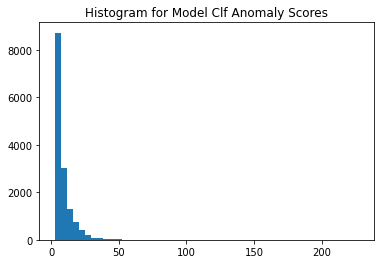

In [ ]:
# Get the outlier scores for the train data
y_train_scores = clf.decision_scores_  

# Predict the anomaly scores
y_test_scores = clf.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

# Plot it
plt.hist(y_test_scores, bins=50)  
plt.title("Histogram for Model Clf Anomaly Scores")
plt.show()

In [ ]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score'] < 65, 0, 1)
df_test['cluster'].value_counts()

#df_test.groupby('cluster').mean()

0    14665
1       19
Name: cluster, dtype: int64

In [ ]:
df_test[df_test['cluster'] == 1]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,score,cluster
48,0.470859,-0.679252,0.497007,0.561331,-0.005519,0.483743,0.285368,-0.181662,0.401612,-0.579525,-0.217515,0.262267,0.107856,0.056929,-0.258829,0.703594,-0.618025,-0.788074,0.547805,0.338972,0.620841,0.128550,-0.039521,0.224328,0.230984,0.354178,0.022808,0.125351,-0.879478,0.488989,0.354730,0.145892,0.319013,-0.584502,0.522509,0.199700,0.012798,-0.528885,0.264132,0.627560,...,-0.308335,-0.072857,-0.324544,-0.649431,-0.599012,-0.816082,-0.373081,-0.043528,0.0,-0.014295,69.955100,-0.035698,-0.008386,-0.036641,-0.015606,-0.023881,-0.157726,-0.016495,1.663246,0.259809,-0.197823,-0.043528,0.764085,-0.169973,-0.097670,-0.075448,0.003763,-0.154301,-0.074488,0.073955,-0.245989,0.389181,-0.099894,-0.101599,1.640373,2.099684,-0.102942,-0.402341,70.202246,1
2209,-0.692797,3.222087,-4.614541,-5.172130,-8.200087,-4.302430,-2.629551,11.673441,-0.973388,0.997168,0.733188,-5.883836,4.490482,-6.942448,-2.968827,-8.355072,6.195876,5.618639,0.531921,0.881928,6.210051,-5.170594,-6.220373,3.999119,-0.692309,-6.213458,4.450601,4.756790,1.559309,0.213070,-5.498631,-3.999690,-1.570107,-1.687014,-1.229558,2.407675,1.107213,2.686761,1.629543,-6.077513,...,-5.719493,13.350703,1.906293,3.582631,3.253835,3.963008,2.343327,-0.043528,0.0,-0.014295,-0.017472,-0.035698,-0.008386,-0.036641,9.338064,0.069482,68.419651,-0.016495,1.017055,62.101556,10.917350,-0.043528,1.144967,-0.169973,-0.097670,-0.075448,-0.115957,-0.154301,-0.166286,9.100523,16.651457,24.515401,11.309212,13.646628,-0.289376,-0.309718,1.153070,-0.292639,109.824540,1
2664,1.977276,2.321368,-2.364634,-0.458156,-5.739293,-0.530451,-0.551648,1.661844,1.574590,7.466243,-3.249071,-2.405143,1.544547,-0.533037,2.385487,-0.518211,2.983439,-1.832828,-5.977751,-6.443194,-0.988818,-2.961755,1.407470,-1.551994,7.079585,-1.092886,-2.351607,-0.732758,2.051064,-0.518822,-3.031021,-6.916405,3.662936,1.066329,1.639537,-2.844803,-0.391394,4.859958,-1.879018,-1.318859,...,-2.488183,5.887785,7.303482,3.179578,13.046486,17.431354,4.380634,-0.043528,0.0,-0.014295,-0.017472,-0.035698,-0.008386,104.969479,-0.015606,-0.023881,2.487132,-0.016495,10.063724,2.360412,8.030759,-0.043528,0.844086,-0.169973,-0.097670,-0.075448,-0.115957,-0.154301,-0.166286,-0.191533,-0.245989,33.887854,-0.099894,-0.101599,-0.294984,-0.317304,-0.083695,-0.209231,118.192219,1
2894,2.084153,5.794035,-4.632639,2.204882,-2.451859,-10.112606,-3.160159,22.214273,14.467993,5.078030,-14.683712,-9.427407,13.163806,-6.178677,13.665481,-14.395698,12.681803,-2.166053,1.571606,-4.556691,0.687908,-0.823745,-14.801929,-0.825416,-14.919173,-13.030530,0.666562,12.925935,-3.643710,4.413236,-14.789378,-2.411144,-16.342678,-0.285091,-8.973608,-24.028774,-16.553492,-4.143341,7.980463,-18.249053,...,-6.989188,5.936246,-0.324544,-0.649431,-0.599012,-0.816082,-0.373081,-0.043528,0.0,-0.014295,-0.017472,-0.035698,-0.008386,-0.036641,-0.015606,-0.023881,24.779502,-0.016495,-0.275326,22.106078,5.671180,-0.043528,0.399915,-0.169973,-0.097670,-0.075448,-0.115957,19.191755,15.072227,3.737679,1.027688,-0.283483,-0.099894,-0.101599,-0.274521,-0.266175,1.351239,0.949723,117.995034,1
2962,-12.164646,-4.135077,-2.177586,-0.929955,-0.132217,-8.640062,4.984879,0.589131,-9.547257,0.021026,-11.188897,-7.455910,2.309916,1.530089,-5.882931,-6.829181,0.963729,2.474084,-4.392880,-11.669774,15.285292,0.196285,1.886239,0.150419,-0.338620,-7.989779,2.178821,-7.719702,7.100955,0.606402,-9.283025,-0.669301,4.844931,1.883373,-5.461451,-9.106582,3.197117,1.688305,1.659062,1.761439,...,2.632596,3.416300,-0.324544,-0.649431,-0.599012,-0.816082,-0.373081,-0.043528,0.0,-0.014295,-0.017472,-0.035698,-0.008386,-0.036641,119.243690,-0.023881,-0.157726,-0.016495,-0.275326,-0.160312,5.108235,-0.043528,0.536432,3.339120,5.301475